In [124]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import time 
import matplotlib.pyplot as plt
from scipy import stats
from PIL import Image
import requests
from io import BytesIO
import cv2 as cv2

In [144]:
rental_train = pd.read_json('train.json')

# response = requests.get(rental_train.iloc[1876].photos[0])
# img = Image.open(BytesIO(response.content))

rental_train['company_name'] = rental_train['photos'].head(10000).apply(match_company 
                                                            , match_image_name = 'bond.png' 
                                                            , return_name = 'bond')
rental_train.head(10000)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,company_name
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,not match
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,not match
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,not match
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium,not match
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low,bond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25231,2.0,3,5537c190c2f21e3fde7786bedb2bc7c5,2016-06-03 05:48:41,"Location, Location, Location!!! If the perfect...",Murray Street,"[Doorman, Elevator, Laundry in Unit, Dishwashe...",40.7139,7105112,-74.0084,42339fa15b8352095da128f1185dc7ca,[https://photos.renthop.com/2/7105112_b92861ff...,4500,25 Murray Street,high,not match
25232,1.0,3,ce6d18bf3238e668b2bf23f4110b7b67,2016-06-14 12:43:41,NO BROKER FEE!!! The Apartment: Amazing deal ...,John St.,"[Balcony, Doorman, Elevator, Fitness Center, G...",40.7081,7157787,-74.0065,cc9f025e89487efb14bf6b0cac286ef0,[https://photos.renthop.com/2/7157787_00b966dd...,4350,100 John St.,medium,bond
25233,1.0,1,ec12b4db154a9c75983f5e32edd93843,2016-06-25 06:08:55,Under Gut Renovation!!! Large 1 Bedroom / 1 Ba...,East 46th Street,"[Doorman, Elevator, Pre-War, Dogs Allowed, Cat...",40.7538,7217032,-73.9740,18b801a90df27a4ea2452b1321a541ab,[https://photos.renthop.com/2/7217032_9aa53b6c...,2714,140 East 46th Street,medium,not match
25234,3.0,3,49ae77ede3dbc66049f796dc8efacfe6,2016-06-01 03:13:54,FIFTH AVENUE AND 70s. - LOCATION DOESN'T GET A...,5th Ave.,"[Dining Room, Doorman, Elevator, Laundry in Bu...",40.7748,7089461,-73.9651,c9c33695ee2a2f818e9f1d8f7d1c4b39,[https://photos.renthop.com/2/7089461_ac3512f3...,15000,945 5th Ave.,low,bond


In [ ]:
response = requests.get(rental_train.loc[15].photos[0])
img = Image.open(BytesIO(response.content))
img

In [143]:
# Cite: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html


def match_company(photo_url_list, match_image_name, return_name):
    MIN_MATCH_COUNT = 10
    
    if ( len(photo_url_list) == 0):
        return "not match"
    
    response = requests.get(photo_url_list[0])
    img = Image.open(BytesIO(response.content))

    image_data = np.asarray(img)
    img1 = image_data               # queryImage
    img2 = cv2.imread(match_image_name,0) # trainImage

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good) > MIN_MATCH_COUNT:
        return return_name
    else:
        return "not match"


not match


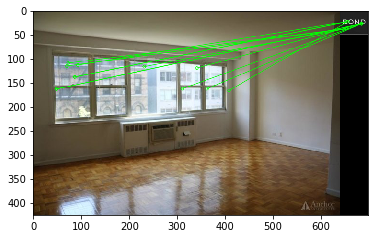

(<matplotlib.image.AxesImage at 0x7f2c443d7990>, None)

In [142]:
response = requests.get(rental_train.iloc[10].photos[0])
img = Image.open(BytesIO(response.content))
img

MIN_MATCH_COUNT = 12

image_data = np.asarray(img)
img1 = image_data               # queryImage
img2 = cv2.imread('bond.png',0) # trainImage

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    hw = img1.shape
    h = hw[0]
    w = hw[1]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)



else:
    print("not match")
    matchesMask = None


draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()
